In [22]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .master('local') \
    .appName('ETL') \
    .config('spark.executor.memory', '5gb') \
    .config("spark.cores.max", "6") \
    .getOrCreate()
sc = spark.sparkContext
from pyspark.sql.window import Window
from pyspark.sql import functions as F

In [23]:
from pyspark.sql.types import StructType, StructField, IntegerType, TimestampType, BooleanType, StringType

schema = StructType([
    StructField("timestamp", TimestampType(), True),
    StructField("stream", IntegerType(), True),
    StructField("sent", BooleanType(), True),
    StructField("seqnum", IntegerType(), True),
    StructField("ack", BooleanType(), True),
    StructField("acknum", IntegerType(), True)
])

In [24]:
def read_npz_to_df(filename):
    data = np.load(filename+'.npz')['packets']
    pd_df = pd.DataFrame(data=data)
    pd_df.drop(columns=['src', 'dst', 'src_port', 'dst_port'], inplace=True)
    pd_df.to_csv(filename+'.csv', index=False)
    df = spark.read.option("header", "true").csv(filename+'.csv')    
    return df

def find_ack_for_seq(df):
    df.createOrReplaceTempView("df")
    df_joined = spark.sql("""
                select df1.stream, df1.timestamp, df1.sent, df1.seqnum, min(df2.timestamp) as acktimestamp 
                from df df1 inner join df df2 
                on df1.seqnum<df2.acknum 
                and df1.sent!=df2.sent
                and df1.stream=df2.stream
                group by df1.stream, df1.timestamp, df1.seqnum, df1.sent
                order by df1.stream
                """)
    return df_joined

def shift_windows(df, streamno):
    shift_window = Window.partitionBy().orderBy('timestamp')
    #calculate sequence length
    df.createOrReplaceTempView("df")

    df_shifted = spark.sql("select * from df where stream={} and sent=True".format(streamno))

    df_shifted = df_shifted.withColumn('seqnum_1', F.lag(df_shifted.seqnum).over(shift_window))
    df_shifted = df_shifted.withColumn('seqlength', F.when(F.isnull(df_shifted.seqnum - df_shifted.seqnum_1), 0)
                          .otherwise(df_shifted.seqnum - df_shifted.seqnum_1))
    #calculate g_in
    df_shifted = df_shifted.withColumn('timestamp_1', F.lag(df_shifted.timestamp).over(shift_window))
    df_shifted = df_shifted.withColumn('gin', F.when(F.isnull(df_shifted.timestamp - df_shifted.timestamp_1), 0)
                          .otherwise(df_shifted.timestamp - df_shifted.timestamp_1))
    #calculate g_ack
    df_shifted = df_shifted.withColumn('acktimestamp_1', F.lag(df_shifted.acktimestamp).over(shift_window))
    df_shifted = df_shifted.withColumn('gack', F.when(F.isnull(df_shifted.acktimestamp - df_shifted.acktimestamp_1), 0)
                          .otherwise(df_shifted.acktimestamp - df_shifted.acktimestamp_1))
    return df_shifted

def sanity_check(df):
    df.createOrReplaceTempView("df_shifted")
    df_sanity = spark.sql("""
                            select  timestamp, timestamp_1, seqnum, seqnum_1, seqlength, gin 
                            from df_shifted 
                            where df_shifted.seqlength<0 
                            and sent=True 
                            and stream=0 
                            order by timestamp asc
                            """)
    if df_sanity.count()==0:
        return True
    else:
        return False

def get_stream_arrays(df, streamno):
    df.createOrReplaceTempView("df_stream")
    stream = spark.sql("""
                        select * from df_stream
                        where df_stream.stream={}
                        """.format(streamno))\
    .rdd.map(lambda row: (row.timestamp, row.seqlength, row.gin, row.gack))
    ts_array = np.array(stream.map(lambda ts_l: ts_l[0]).collect())
    l_array = np.array(stream.map(lambda ts_l: ts_l[1]).collect())
    gin_array = np.array(stream.map(lambda ts_l: ts_l[2]).collect())
    gack_array = np.array(stream.map(lambda ts_l: ts_l[3]).collect())
    return ts_array, l_array, gin_array, gack_array

In [32]:
import glob, os
os.chdir("dumpfiles")
for file in glob.glob("*.npz"):
    print(file)
os.chdir('../')

dumpfile_885_9_92.npz
dumpfile_10000_10_1055.npz
dumpfile_545_9_90.npz
dumpfile_10000_10_722.npz
dumpfile_10000_10_833.npz
dumpfile_3792_4_474.npz
dumpfile_10000_11_1060.npz
dumpfile_2335_33_35.npz


In [42]:
filename = 'dumpfiles/dumpfile_3792_4_474.npz'
filename = filename.split('.npz')[0]
print(filename)
streamno = 0
df = read_npz_to_df(filename)
df_joined = find_ack_for_seq(df)
df_shifted = shift_windows(df_joined, streamno)
if sanity_check(df_shifted):
    ts_array, l_array, gin_array, gack_array = get_stream_arrays(df_shifted, streamno)

dumpfiles/dumpfile_3792_4_474


In [43]:
df.filter(df.stream==0).show()

+----------------+------+-----+----------+----+----------+
|       timestamp|stream| sent|    seqnum| ack|    acknum|
+----------------+------+-----+----------+----+----------+
|1561031517283414|     0| True|2587327968|True| 106428016|
|1561031517283507|     0|False| 106428016|True|2587335208|
|1561031517287049|     0| True|2587335208|True| 106428016|
|1561031517287094|     0|False| 106428016|True|2587336656|
|1561031517309489|     0| True|2587336656|True| 106428016|
|1561031517309579|     0|False| 106428016|True|2587346792|
|1561031517315877|     0| True|2587346792|True| 106428016|
|1561031517315948|     0|False| 106428016|True|2587349688|
|1561031517334975|     0| True|2587349688|True| 106428016|
|1561031517335055|     0|False| 106428016|True|2587358376|
|1561031517347810|     0| True|2587358376|True| 106428016|
|1561031517347852|     0|False| 106428016|True|2587364168|
|1561031517450370|     0| True|2587364168|True| 106428016|
|1561031517450413|     0|False| 106428016|True|258736706

2839.5097636176774 480.04028089510956 0.0 10136.0 2896.0


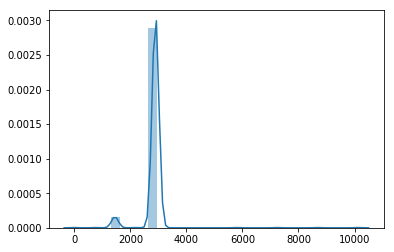

In [44]:
sns.distplot(l_array)
print(l_array.mean(), l_array.std(), l_array.min(), l_array.max(), np.median(l_array))

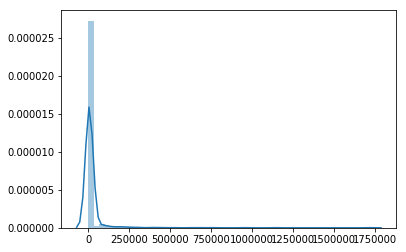

In [45]:
sns.distplot(gin_array)

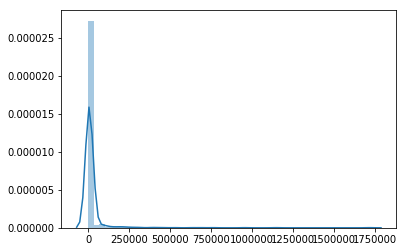

In [46]:
sns.distplot(gack_array)

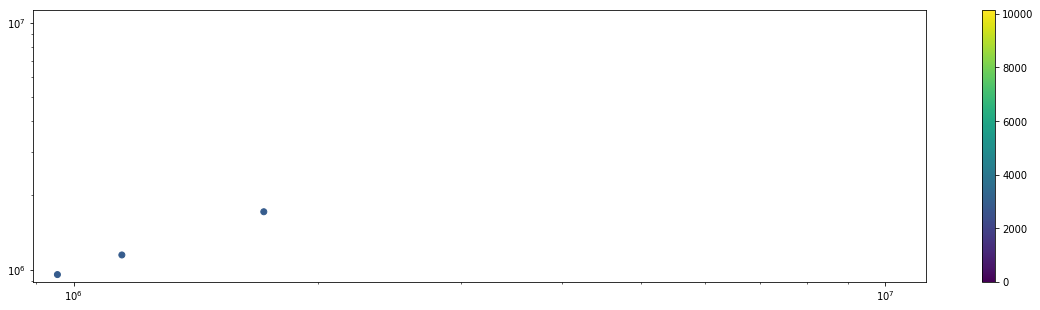

In [47]:
plt.figure(figsize=(20,5))
plt.scatter(gin_array, gack_array, c=l_array)
plt.yscale('log')
plt.xscale('log')
plt.colorbar()

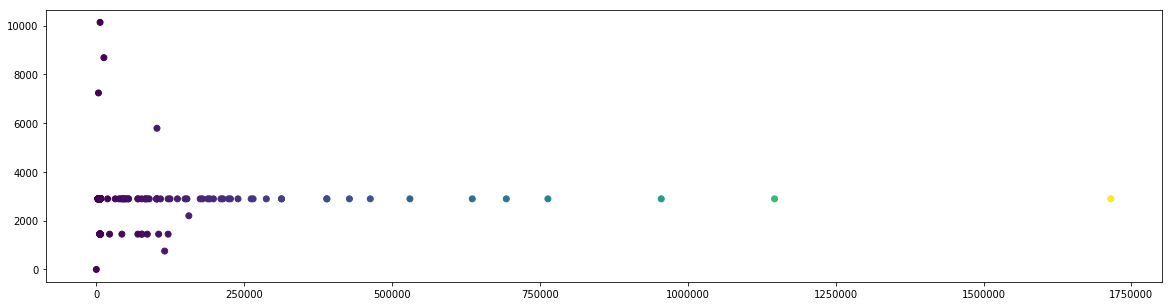

In [48]:
plt.figure(figsize=(20,5))
plt.scatter(gin_array, l_array, c=gack_array)
#plt.yscale('log')
#plt.xscale('log')

/home/saghar/.virtualenvs/bandwidth/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


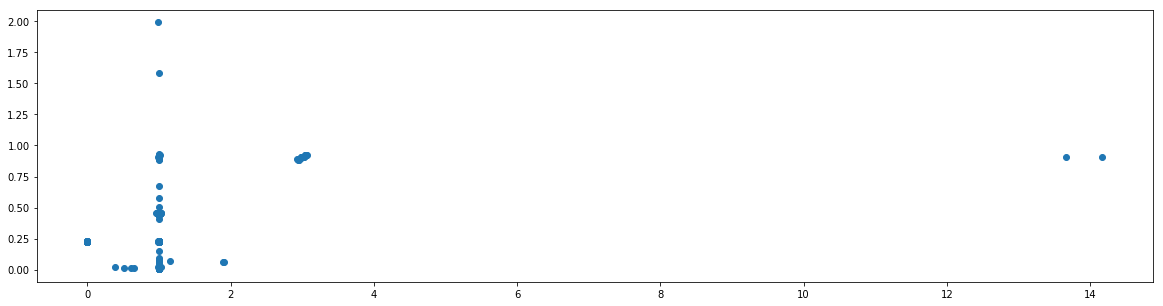

In [49]:
plt.figure(figsize=(20,5))
plt.plot(gack_array/gin_array, l_array/gin_array, 'o')
#plt.yscale('log')
#plt.xscale('log')


In [50]:
df_shifted.select(['gin', 'gack']).show()
#df_shifted.select('gin').rdd.flatMap(list).collect()

+--------+--------+
|     gin|    gack|
+--------+--------+
|     0.0|     0.0|
|  3635.0|  3587.0|
| 22440.0| 22485.0|
|  6388.0|  6369.0|
| 19098.0| 19107.0|
| 12835.0| 12797.0|
|102560.0|102561.0|
|  4999.0|  5029.0|
|156431.0|156404.0|
|  6390.0|  6385.0|
|  6389.0|  6431.0|
|  6384.0|  6345.0|
|  6388.0|  6389.0|
|  3194.0|  3192.0|
|  6394.0|  6394.0|
|  6382.0|  6384.0|
|  6398.0|  6394.0|
|  6383.0|  6381.0|
|  6404.0|  6433.0|
|  3186.0|  3191.0|
+--------+--------+
only showing top 20 rows

